## Modules

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import os
import sys
import netCDF4 as nc
#sys.path.append(os.getcwd()+'/conditional-stats/src/')
sys.path.insert(0, os.getcwd()+'/../conditional-stats/src/')
import conditionalstats as cs

#### Collect Data 

In [2]:
nc_rcemip1 = nc.Dataset("/bdd/MT_WORKSPACE/REMY/RCEMIP/SAM/300K/rcemip_large_2048x128x74_3km_12s_300K_64.2Dcom_2.nc")

In [3]:
nc1 = nc_rcemip1
prec = nc1["Prec"][:]
print(nc1["Prec"])

<class 'netCDF4._netCDF4.Variable'>
float32 Prec(time, y, x)
    long_name: Surface Precip. Rate
    units: mm/day
unlimited dimensions: time
current shape = (201, 128, 2048)
filling on, default _FillValue of 9.969209968386869e+36 used


In [4]:
print(np.shape(prec))
prec_over_time = np.mean(prec[:], axis = (1,2))
prec_over_xy = np.mean(prec, axis = (0))

(201, 128, 2048)


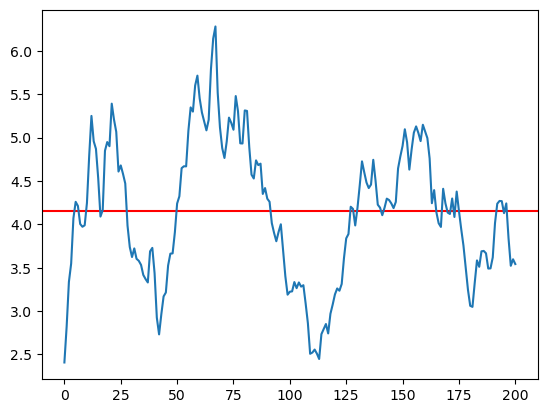

In [5]:
fig, ax = plt.subplots()

ax.axhline(y=np.mean(prec_over_time), color = 'r')
ax.plot(prec_over_time)

In [6]:
## TODO : better put the null values to nan so that they don't interfere when looking at mean (np.nanmean)
#prec_shape = np.shape(prec)
#prec_no_null = prec[np.where(prec!=0)].reshape(prec_shape)
#print(np.shape(prec_no_null))
#prec_no_null_over_time = np.mean(prec_no_null[:], axis = (1,2))
#prec_no_null_over_xy = np.mean(prec_no_null, axis = (0))


In [7]:
intense_idx = [i for i in range(len(prec_over_time)) if prec_over_time[i]>np.mean(prec_over_time)]
calm_idx = [i for i in range(len(prec_over_time)) if i not in intense_idx]

print(intense_idx)


[5, 6, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 127, 128, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 168, 169, 172, 174, 175, 192, 193, 194, 196]


In [8]:
high_prec_timestop = [(10,28), (50,92), (127, 175)]
low_prec_timestop = [(0,10), (28,50), (92, 127), (175,200)]
high_rain_idx = [i for i in range(10, 28)] + [i for i in range(50, 92)] + [i for i in range(127, 175)]
low_rain_idx = [i for i in range(len(prec_over_time)) if i not in intense_idx]
low_prec = prec_over_time[low_rain_idx]
high_prec = prec_over_time[high_rain_idx]

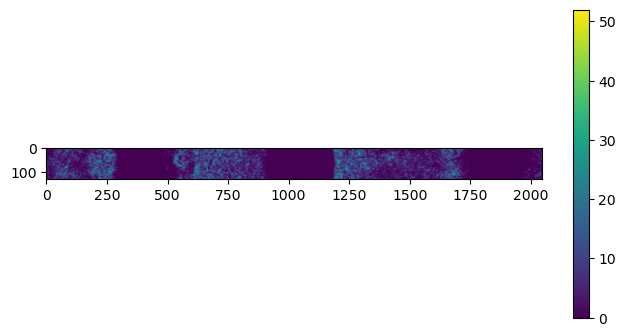

In [9]:
fig = plt.figure(figsize = (8,4))
plt.imshow(prec_over_xy, cmap='viridis')
plt.colorbar()
plt.show()

In [10]:
data_high = []
data_low = []

for t in high_prec_timestop:
    start,end = t
    nc_t = nc1["Prec"][start:end, :, : ].flatten()
    or_len = len(nc_t)
    nc_t = nc_t[np.where(nc_t!=0)]
    data_high.append(nc_t)
    fin_len = len(nc_t)
    print(f"0 represented {1-(fin_len/or_len)}% of our datasets, now we have {fin_len} points")

for t in low_prec_timestop:
    start,end = t
    nc_t = nc1["Prec"][start:end, :, : ].flatten()
    nc_t = nc_t[np.where(nc_t!=0)]
    data_low.append(nc_t)  

0 represented 0.8951299455430772% of our datasets, now we have 494839 points
0 represented 0.9045186723981585% of our datasets, now we have 1051254 points
0 represented 0.9042143026987711% of our datasets, now we have 1205263 points


In [11]:
dist_linear = cs.Distribution(name = 'high 0', nbins =40)
dist_linear.computeDistribution(sample = data_high[0], vmax = np.max(data_high[0]), vmin = np.min(data_high[0]))
print(len(dist_linear.bins))

41


Text(0, 0.5, 'Cumulative density (CDF)')

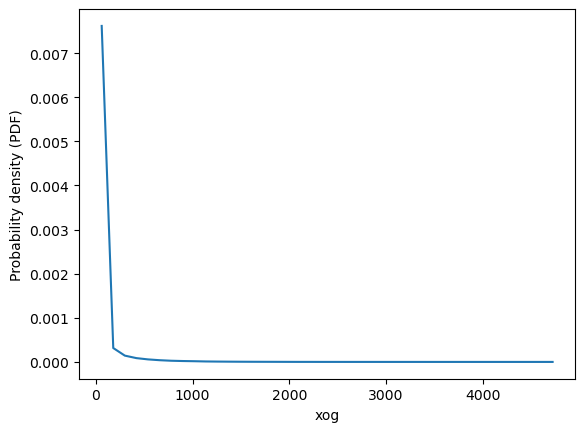

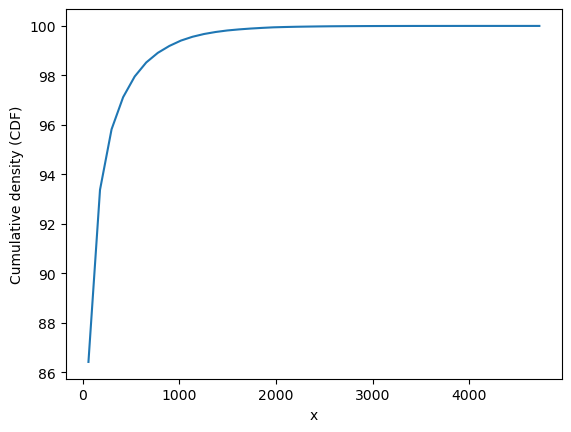

In [12]:
d = dist_linear
plt.plot(d.percentiles,d.density)
plt.xlabel('xog')
plt.ylabel('Probability density (PDF)')
plt.figure()
plt.plot(d.percentiles,d.ranks)
plt.xlabel('x')
plt.ylabel('Cumulative density (CDF)')

In [13]:
dist_log = cs.Distribution(name = 'high 0', nbins = 140, bintype = 'log')
dist_log.computeDistribution(sample = data_high[0], vmax = np.max(data_high[0]), vmin = np.min(data_high[0])+1e-10)

Text(0.5, 0, 'x')

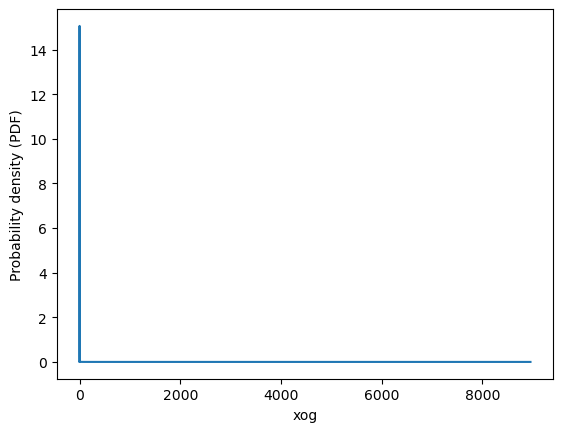

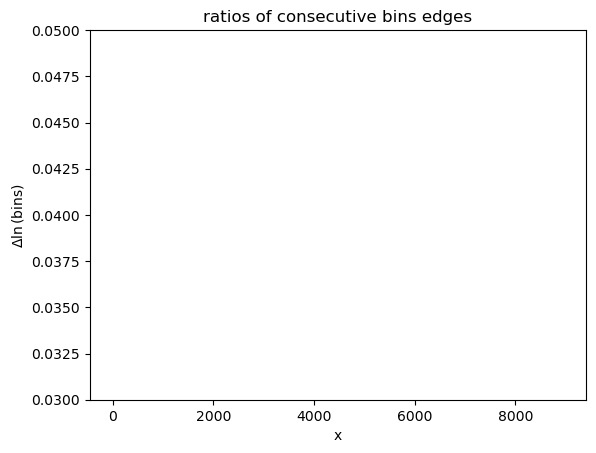

In [14]:
d = dist_log
plt.plot(d.percentiles,d.density)
plt.xlabel('xog')
plt.ylabel('Probability density (PDF)')
plt.figure()

bin_ratios = np.log(d.bins[1:]/d.bins[:-1]) ## Ok j'ai pas compris finalement
plt.plot(d.percentiles,bin_ratios)
# plt.xscale('log')
plt.title('ratios of consecutive bins edges')
plt.ylim((0.03,0.05))
plt.ylabel(r'$\Delta \ln$(bins)')
plt.xlabel('x')

In [16]:
dist_linQ = cs.Distribution(name='x',bintype='linQ')
dist_linQ.computeDistribution(sample = data_high[0], vmax = np.max(data_high[0]), vmin = np.min(data_high[0]))

[  4948.38  14845.14  24741.9   34638.66  44535.42  54432.18  64328.94
  74225.7   84122.46  94019.22 103915.98 113812.74 123709.5  133606.26
 143503.02 153399.78 163296.54 173193.3  183090.06 192986.82 202883.58
 212780.34 222677.1  232573.86 242470.62 252367.38 262264.14 272160.9
 282057.66 291954.42 301851.18 311747.94 321644.7  331541.46 341438.22
 351334.98 361231.74 371128.5  381025.26 390922.02 400818.78 410715.54
 420612.3  430509.06 440405.82 450302.58 460199.34 470096.1  479992.86
 489889.62]
51
[2.6526186  0.05201213 0.05201213 ... 2.7331505  0.05466301 0.05466301]
rank_edges <class 'numpy.ndarray'>
bins [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan] (51,)
[ 50887.10249275 142195.26727881 214723.92062923 272335.477812
 318097.9643287  354448.39946011 383322.5764295  406258.15045072
 424476.52447538 438947.89335393 45

ValueError: could not broadcast input array from shape (40,) into shape (49,)

ValueError: x, y, and format string must not be None

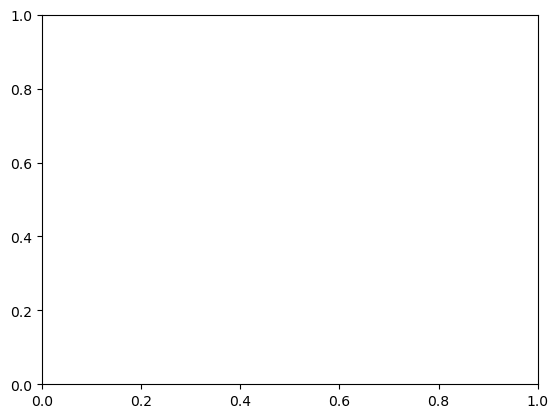

In [19]:
d = dist_linQ
plt.plot(d.percentiles,d.density) ## MJC : Petit souci avec les density qui ne devraient vraiment pas dépasser 1 ? 
plt.xscale('log')
plt.xlabel('x')
plt.ylabel('Probability density (PDF)')

plt.figure()
plt.plot(d.percentiles,d.ranks)
plt.xscale('log')
plt.xlabel('x')
plt.ylabel('Cumulative density (CDF)')

In [3]:
import numpy as np 
import matplotlib.pyplot as plt 
import os
import sys
import netCDF4 as nc
#sys.path.append(os.getcwd()+'/conditional-stats/src/')
sys.path.insert(0, os.getcwd()+'/../conditional-stats/src/')
import conditionalstats as cs

nc_rcemip1 = nc.Dataset("/bdd/MT_WORKSPACE/REMY/RCEMIP/SAM/300K/rcemip_large_2048x128x74_3km_12s_300K_64.2Dcom_2.nc")

nc1 = nc_rcemip1
prec = nc1["Prec"][:]

##from dataviz
high_prec_timestop = [(10,28), (50,92), (127, 175)]
low_prec_timestop = [(0,10), (28,50), (92, 127), (175,200)]
high_rain_idx = [i for i in range(10, 28)] + [i for i in range(50, 92)] + [i for i in range(127, 175)]
low_rain_idx = [i for i in range(len(prec_over_time)) if i not in intense_idx]
low_prec = prec_over_time[low_rain_idx]
high_prec = prec_over_time[high_rain_idx]


##cleaning data
data_high = []
data_low = []


for t in high_prec_timestop:
    start,end = t
    nc_t = nc1["Prec"][start:end, :, : ].flatten()
    or_len = len(nc_t)
    nc_t = nc_t[np.where(nc_t!=0)]
    data_high.append(nc_t)
    fin_len = len(nc_t)
    print(f"0 represented {1-(fin_len/or_len)}% of our datasets, now we have {fin_len} points")

for t in low_prec_timestop:
    start,end = t
    nc_t = nc1["Prec"][start:end, :, : ].flatten()
    nc_t = nc_t[np.where(nc_t!=0)]
    data_low.append(nc_t)  

    

dist_invlogQ = cs.Distribution(name='x',bintype='invlogQ',nd=4,fill_last_decade=True)
dist_invlogQ.computeDistribution(sample = data_high[0], vmax = np.max(data_high[0]), vmin = np.min(data_high[0]))

NameError: name 'high_prec_timestop' is not defined

In [21]:
bins = np.array([np.nan]*(42))
sample_no_nan = data_high[0][np.logical_not(np.isnan(data_high[0]))]

rank_edges = [0, 10.283588263785926, 28.735721039776262, 43.392771094626724
 ,55.035279790961525 ,64.28325317148324 ,71.6291795416102, 77.4642562676077
 ,82.09922246285004 ,85.78090697872359 ,88.70537294102917, 91.0283588263786
 ,92.87357210397764 ,94.33927710946267 ,95.50352797909615, 96.42832531714834
 ,97.16291795416103 ,97.74642562676077 ,98.209922246285, 98.57809069787237
 ,98.87053729410292 ,99.10283588263786 ,99.28735721039776, 99.43392771094626
 ,99.55035279790961 ,99.64283253171483 ,99.71629179541611, 99.77464256267608
 ,99.8209922246285 ,99.85780906978724 ,99.8870537294103 ,99.91028358826378
 ,99.92873572103977 ,99.94339277109464 ,99.95503527979096, 99.96428325317149
 ,99.97162917954161 ,99.97746425626761 ,99.98209922246285, 99.98578090697873
 ,99.98870537294103, None]

bins[1:-1] = np.percentile(data_high[0], rank_edges[1:-1])


[ 50887.10249275 142195.26727881 214723.92062923 272335.477812
 318097.9643287  354448.39946011 383322.5764295  406258.15045072
 424476.52447538 438947.89335393 450442.91024928 459573.72672788
 466826.59206292 472587.7477812  477163.99643287 480799.03994601
 483686.45764295 485980.01504507 487801.85244754 489248.98933539
 490398.49102493 491311.57267279 492036.85920629 492612.97477812
 493070.59964329 493434.1039946  493722.8457643  493952.20150451
 494134.38524475 494279.09893354 494394.04910249 494485.35726728
 494557.88592063 494615.49747781 494661.25996433 494697.61039946
 494726.48457643 494749.42015045 494767.63852448 494782.10989335]


In [ ]:
types = []
for x in data_high[0]:
    types.append(type(x))
    np.isnan(x)

for x in types : 
    if x != np.float32 : print(x) 

In [51]:
from numpy import percentile
import inspect
print(inspect.getsource(percentile))


@array_function_dispatch(_percentile_dispatcher)
def percentile(a,
               q,
               axis=None,
               out=None,
               overwrite_input=False,
               method="linear",
               keepdims=False,
               *,
               interpolation=None):
    """
    Compute the q-th percentile of the data along the specified axis.

    Returns the q-th percentile(s) of the array elements.

    Parameters
    ----------
    a : array_like
        Input array or object that can be converted to an array.
    q : array_like of float
        Percentile or sequence of percentiles to compute, which must be between
        0 and 100 inclusive.
    axis : {int, tuple of int, None}, optional
        Axis or axes along which the percentiles are computed. The
        default is to compute the percentile(s) along a flattened
        version of the array.

        .. versionchanged:: 1.9.0
            A tuple of axes is supported
    out : ndarray, optional
      

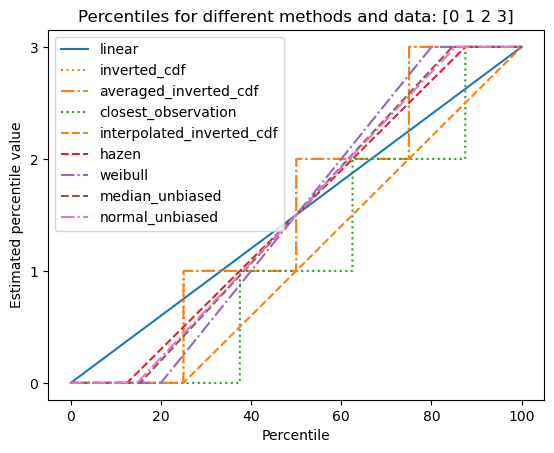

In [52]:
import matplotlib.pyplot as plt

a = np.arange(4)
p = np.linspace(0, 100, 6001)
ax = plt.gca()
lines = [
    ('linear', '-', 'C0'),
    ('inverted_cdf', ':', 'C1'),
    # Almost the same as `inverted_cdf`:
    ('averaged_inverted_cdf', '-.', 'C1'),
    ('closest_observation', ':', 'C2'),
    ('interpolated_inverted_cdf', '--', 'C1'),
    ('hazen', '--', 'C3'),
    ('weibull', '-.', 'C4'),
    ('median_unbiased', '--', 'C5'),
    ('normal_unbiased', '-.', 'C6'),
    ]
for method, style, color in lines:
    ax.plot(
        p, np.percentile(a, p, method=method),
        label=method, linestyle=style, color=color)
ax.set(
    title='Percentiles for different methods and data: ' + str(a),
    xlabel='Percentile',
    ylabel='Estimated percentile value',
    yticks=a)
ax.legend()
plt.show()

In [53]:
percentile??


Signature:
percentile(
    a,
    q,
    axis=None,
    out=None,
    overwrite_input=False,
    method='linear',
    keepdims=False,
    *,
    interpolation=None,
)
Source:   
@array_function_dispatch(_percentile_dispatcher)
def percentile(a,
               q,
               axis=None,
               out=None,
               overwrite_input=False,
               method="linear",
               keepdims=False,
               *,
               interpolation=None):
    """
    Compute the q-th percentile of the data along the specified axis.

    Returns the q-th percentile(s) of the array elements.

    Parameters
    ----------
    a : array_like
        Input array or object that can be converted to an array.
    q : array_like of float
        Percentile or sequence of percentiles to compute, which must be between
        0 and 100 inclusive.
    axis : {int, tuple of int, None}, optional
        Axis or axes along which the percentiles are computed. The
        default is to comput